In [168]:
import numpy as np
import pandas as pd
import math

import matplotlib
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Import Data

In [169]:
# Import training and holdout dataframes
train_df = pd.read_csv('kc_house_data_train.csv')
hold_df = pd.read_csv('kc_house_data_test_features.csv')

# Modeling

In [170]:
# Print column names
print(train_df.keys())

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [171]:
# Function to create age range dummy variables
def set_ages(df):
    year = df['yr_built']
    # df['age_new'] = np.where(age==2015, 1, 0)
    df['age_10'] = np.where((year>2004) & (year<2015), 1, 0)
    df['age_20'] = np.where((year>1994) & (year<2005), 1, 0)
    df['age_30'] = np.where((year>1984) & (year<1995), 1, 0)
    df['age_40'] = np.where((year>1974) & (year<1985), 1, 0)
    df['age_50'] = np.where((year>1964) & (year<1975), 1, 0)
    df['age_60'] = np.where((year>1954) & (year<1965), 1, 0)
    df['age_70'] = np.where((year>1944) & (year<1955), 1, 0)
    df['age_80'] = np.where((year>1934) & (year<1945), 1, 0)
    df['age_90'] = np.where((year>1924) & (year<1935), 1, 0)
    df['age_100'] = np.where((year>1914) & (year<1925), 1, 0)
    df['age_old'] = np.where((year<1915), 1, 0)
    return df

# Create age range dummy variables for dataframes
train_df = set_ages(train_df)
hold_df = set_ages(hold_df)

In [172]:
# Function to create renovation age range dummy variables
def set_ren_ages(df):
    year = df['yr_built']
    ren_yr = df['yr_renovated']
    df['not_ren'] = np.where((year!=2015) & (ren_yr==0), 1, 0)
    df['ren_5'] = np.where((ren_yr>2010), 1, 0)
    df['ren_10'] = np.where((ren_yr>2005) & (ren_yr<2011), 1, 0)
    df['ren_15'] = np.where((ren_yr>2000) & (ren_yr<2006), 1, 0)
    df['ren_20'] = np.where((ren_yr>1995) & (ren_yr<2001), 1, 0)
    df['ren_25'] = np.where((ren_yr>1990) & (ren_yr<1996), 1, 0)
    df['ren_30'] = np.where((ren_yr>1985) & (ren_yr<1991), 1, 0)
    # df['ren_old'] = np.where((ren_yr>0) & (ren_yr<1986), 1, 0)
    return df

# Create renovation age range dummy variables for dataframes
train_df = set_ren_ages(train_df)
hold_df = set_ren_ages(hold_df)

In [173]:
# Function for creating year dummy variables
def set_years(df):
    df['year'] = df['date'].apply(lambda x: int(x[0:4]))
    dummies = pd.get_dummies(df['year'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('year', axis=1, inplace=True)
    return df

# Create year dummy variables for dataframes
train_df = set_years(train_df)
hold_df = set_years(hold_df)

In [174]:
# Function for creating month dummy variables
def set_months(df):
    months = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
              7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
    df['month'] = df['date'].apply(lambda x: int(x[4:6]))
    dummies = pd.get_dummies(df['month'], drop_first=True)
    for key in dummies.keys():
        if key in months.keys():
            dummies.rename({key : months[key]}, axis=1, inplace=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('month', axis=1, inplace=True)
    return df

# Create month dummy variables for dataframes
train_df = set_months(train_df)
hold_df = set_months(hold_df)

In [175]:
# Function for creating zipcode dummy variables
def set_zipcodes(df):
    dummies = pd.get_dummies(df['zipcode'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    return df

# Create zipcode dummy variables for dataframes
train_df = set_zipcodes(train_df)
hold_df = set_zipcodes(hold_df)

In [190]:
# Function to transform extreme values
def fix_outliers(df, cols):
    for col in cols:
        if df[col].eq(0).any():
            filt = df[col] == 0
            df[f'{col}_nan'] = np.where(filt, np.nan, df[col])
            std = df[f'{col}_nan'].std()
            mean = df[f'{col}_nan'].mean()
            del df[f'{col}_nan']
        else:
            std = df[col].std()
            mean = df[col].mean()
        value = mean+(4*std)
        df[col] = df[col].apply(lambda x: value if (x>value) else x)
    return df

# Transform extreme values for specified columns dataframes
outlier_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']
train_df = fix_outliers(train_df, outlier_cols)
hold_df = fix_outliers(hold_df, outlier_cols)

# Create Params

In [186]:
# Print column names
print(train_df.keys())

Index([ 'Unnamed: 0',          'id',        'date',       'price',
          'bedrooms',   'bathrooms', 'sqft_living',    'sqft_lot',
            'floors',  'waterfront',
       ...
               98146,         98148,         98155,         98166,
               98168,         98177,         98178,         98188,
               98198,         98199],
      dtype='object', length=121)


In [187]:
# # Split into x dataframes and y series for train and test data
# Y = df['price']
# X = df.drop(['price'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(
#     X, Y, random_state=22,test_size=0.2)

In [188]:
# Function to create features list
def set_features(df):
    ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'yr_renovated',
              'zipcode', 'lat', 'long', 'sqft_living']
    features = list(df.keys())
    for feature in ignore:
        if feature in features:
            features.remove(feature)
    return features

# Create features list for dataframes
train_features = set_features(train_df)
holdout_features = set_features(holdout_df)

# EDA

In [181]:
# Print features list
print(train_features)

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80', 'age_90', 'age_100', 'age_old', 'not_ren', 'ren_5', 'ren_10', 'ren_15', 'ren_20', 'ren_25', 'ren_30', 2015, 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


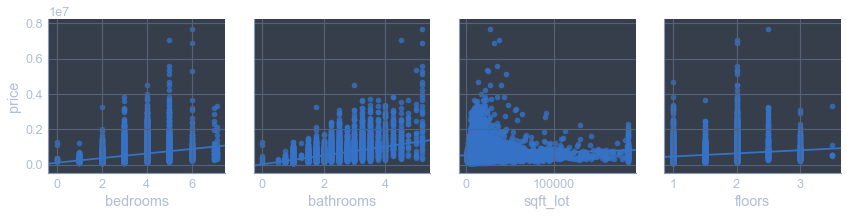

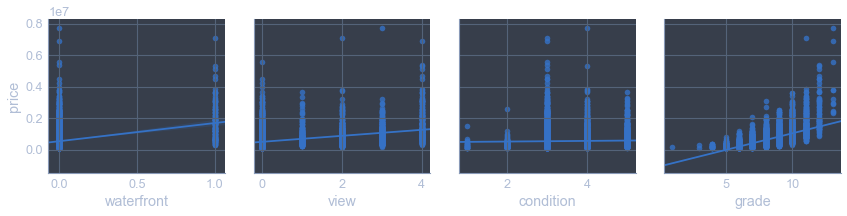

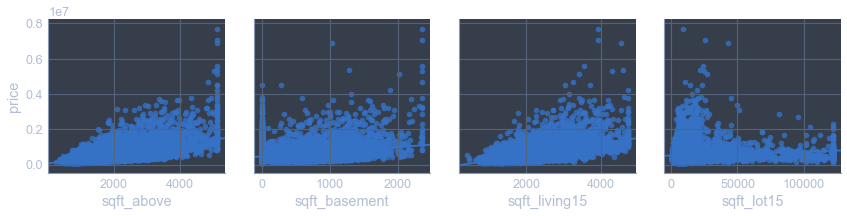

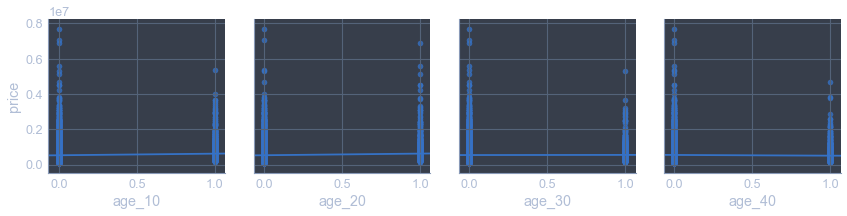

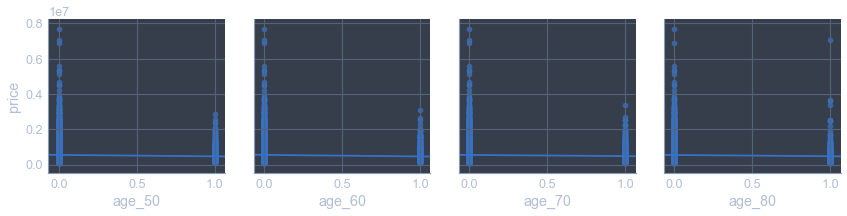

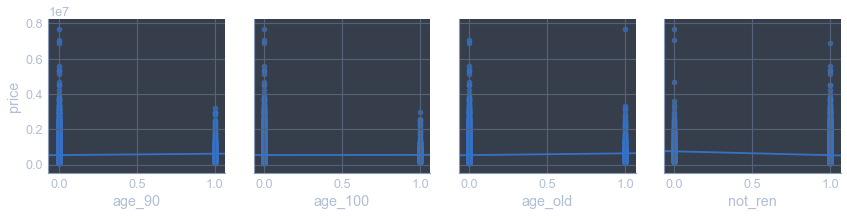

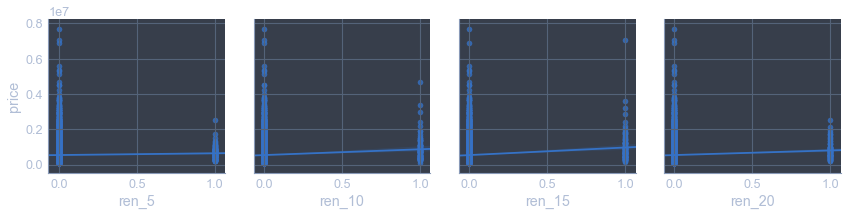

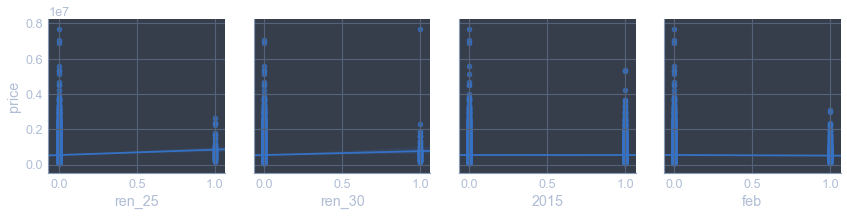

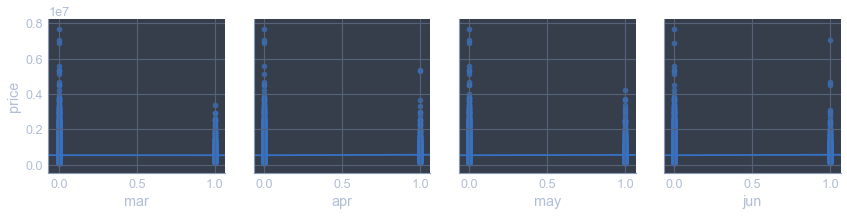

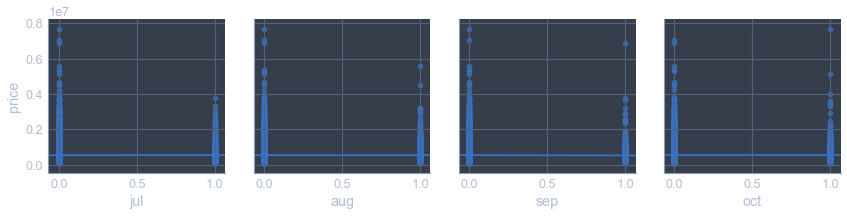

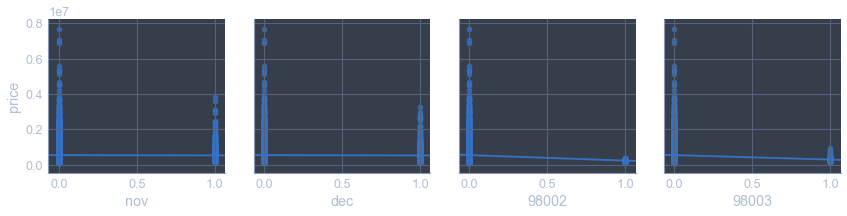

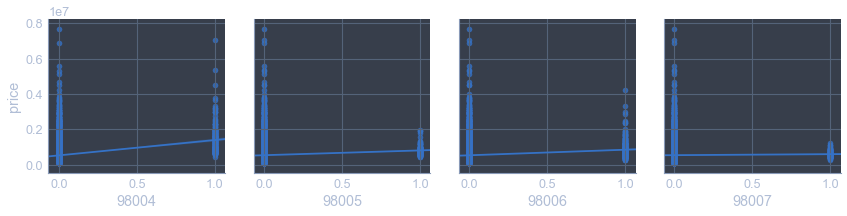

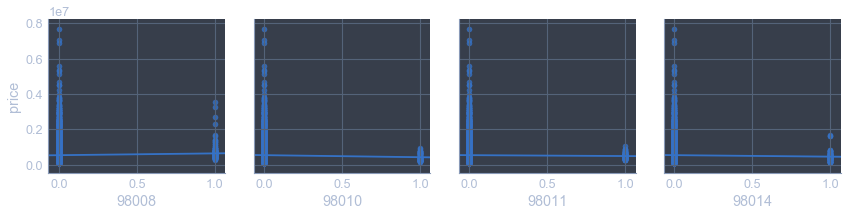

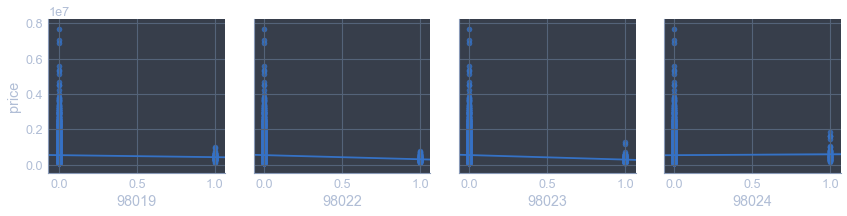

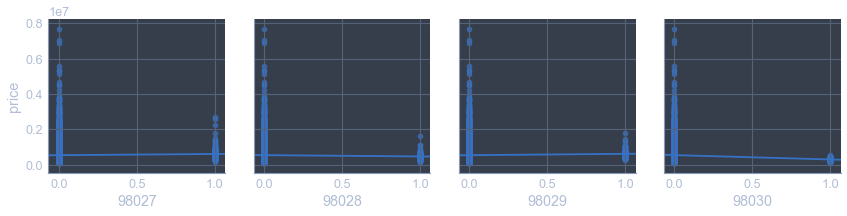

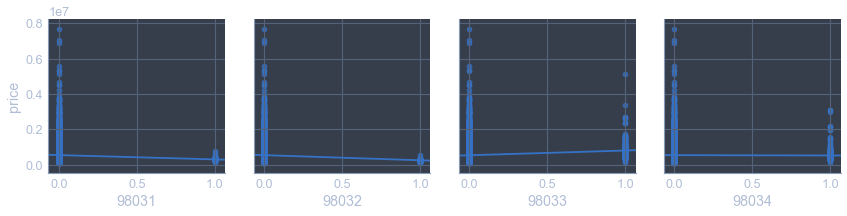

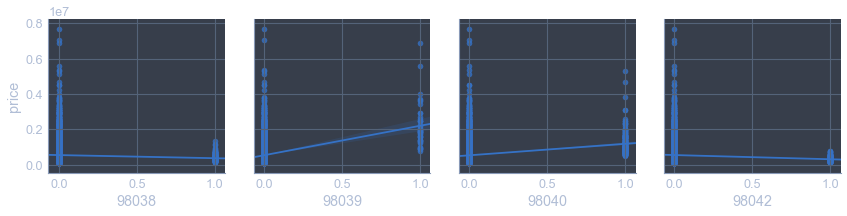

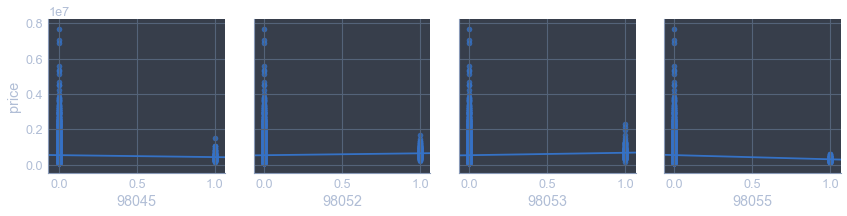

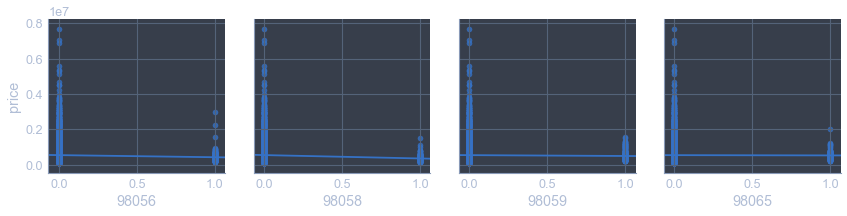

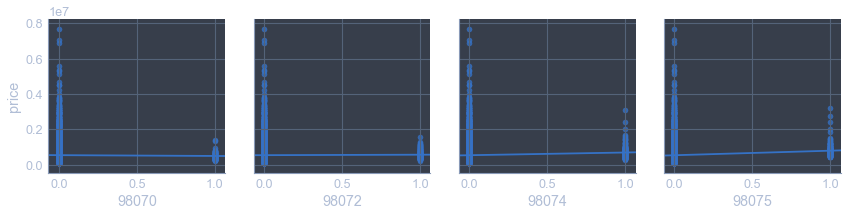

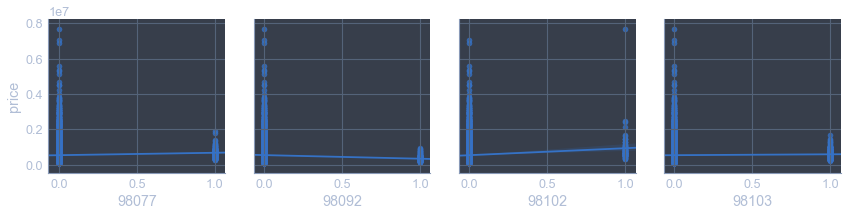

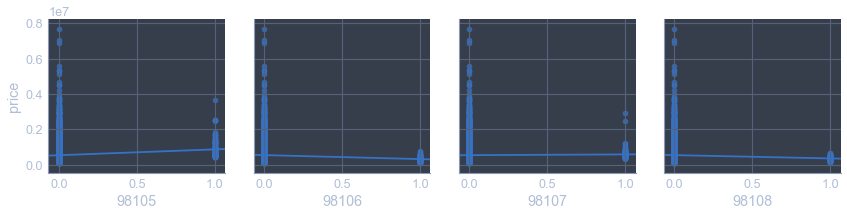

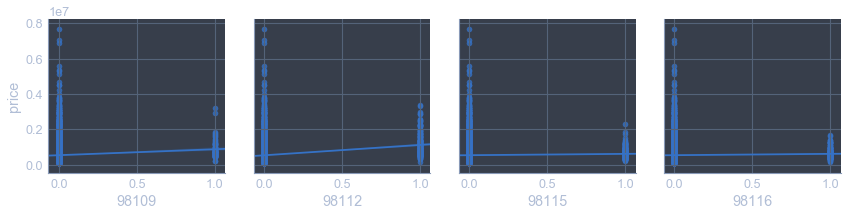

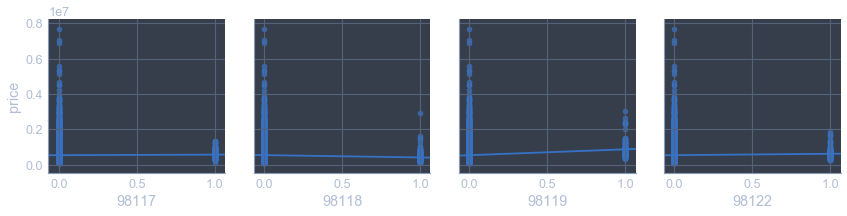

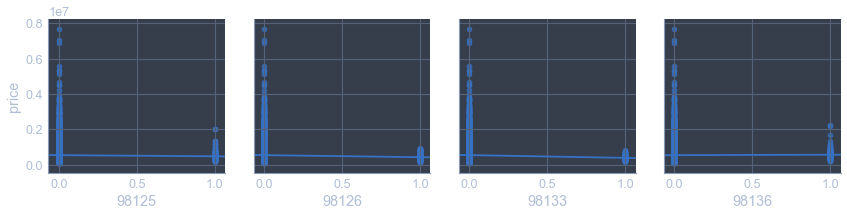

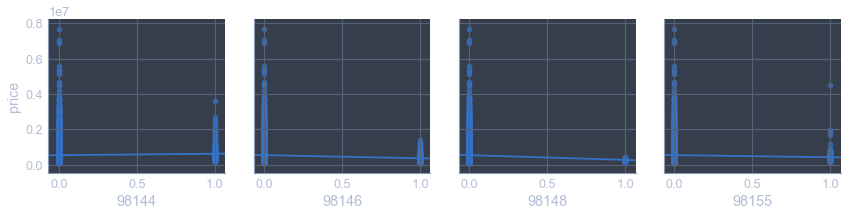

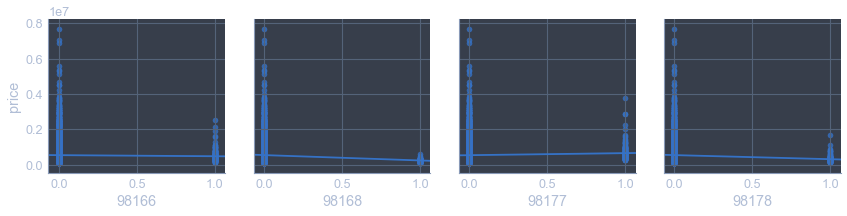

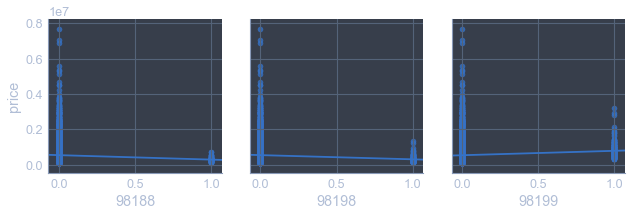

In [182]:
# Function to create feature pplots
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['price'], x_vars=row, kind='reg', height=3)
    return None

# Create feature pplots for training df
pplot_features(train_df, train_features)

# Run Model

In [183]:
# Print features list
print(train_features)

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80', 'age_90', 'age_100', 'age_old', 'not_ren', 'ren_5', 'ren_10', 'ren_15', 'ren_20', 'ren_25', 'ren_30', 2015, 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]


In [191]:
# Function to create regression model
def set_model(df, features):
    model = sm.OLS(df['price'], sm.add_constant(
        df[[key for key in train_features]])).fit()
    return model.summary()

# Run model on training dataframe
set_model(train_df, train_features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     600.9
Date:                Sun, 03 May 2020   Prob (F-statistic):               0.00
Time:                        13:18:05   Log-Likelihood:            -2.3266e+05
No. Observations:               17290   AIC:                         4.655e+05
Df Residuals:                   17178   BIC:                         4.664e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.367e+05   3.91e+04    -16.281      0.000   -7.13e+05    -5.6e+05
bedrooms      -2.281e+04   1946.994    -11.715      0.000   -2.66e+04    -1.9e+04
bathrooms      2.495e+04   3173.301      7.864      0.000    1.87e+04    3.12e+04
sqft_lot          1.0981      0.162      6.764      0.000       0.780       1.416
floors        -4.685e+04   3980.508    -11.770      0.000   -5.47e+04    -3.9e+04
waterfront     6.787e+05   1.63e+04     41.756      0.000    6.47e+05    7.11e+05
view           5.703e+04   2055.556     27.745      0.000     5.3e+04    6.11e+04
condition      2.922e+04   2306.226     12.669      0.000    2.47e+04    3.37e+04
grade           6.72e+04   2173.203     30.922      0.000    6.29e+04    7.15e+04
sqft_above      190.5599      3.777     50.454      0.000     183.157     197.963
sqft_basement   123.3837      4.269     28.901      0.000     115.016     131.752
sqft_living15    14.0278      3.493      4.015      0.000       7.180      20.875
sqft_lot15       -0.5845      0.227     -2.578      0.010      -1.029      -0.140
age_10        -8.643e+04   3.49e+04     -2.477      0.013   -1.55e+05    -1.8e+04
age_20        -9.381e+04    3.5e+04     -2.682      0.007   -1.62e+05   -2.53e+04
age_30        -1.079e+05    3.5e+04     -3.077      0.002   -1.77e+05   -3.92e+04
age_40        -1.022e+05   3.51e+04     -2.910      0.004   -1.71e+05   -3.34e+04
age_50        -9.006e+04   3.52e+04     -2.556      0.011   -1.59e+05    -2.1e+04
age_60        -8.727e+04   3.52e+04     -2.479      0.013   -1.56e+05   -1.83e+04
age_70        -5.982e+04   3.52e+04     -1.700      0.089   -1.29e+05    9134.048
age_80        -1.356e+04   3.52e+04     -0.385      0.700   -8.26e+04    5.55e+04
age_90        -2.398e+04   3.53e+04     -0.680      0.496   -9.31e+04    4.51e+04
age_100       -2.782e+04   3.53e+04     -0.789      0.430   -9.69e+04    4.13e+04
age_old       -1.599e+04   3.51e+04     -0.455      0.649   -8.49e+04    5.29e+04
not_ren        5.839e+04   1.41e+04      4.129      0.000    3.07e+04    8.61e+04
ren_5          1.187e+05   2.05e+04      5.788      0.000    7.85e+04    1.59e+05
ren_10         1.673e+05   2.23e+04      7.493      0.000    1.24e+05    2.11e+05
ren_15         1.709e+05   2.14e+04      7.998      0.000    1.29e+05    2.13e+05
ren_20         4.548e+04   2.31e+04      1.970      0.049     218.467    9.07e+04
ren_25         1.001e+05    2.5e+04      4.006      0.000    5.11e+04    1.49e+05
ren_30         6.393e+04   2.32e+04      2.761      0.006    1.85e+04    1.09e+05
2015           6.443e+04   8817.458      7.307      0.000    4.71e+04    8.17e+04
feb             624.0261   8102.367      0.077      0.939   -1.53e+04    1.65e+04
mar            2.089e+04   7465.548      2.798      0.005    6256.102    3.55e+04
apr            2.943e+04   7245.426      4.062   

# Notes (TESTING)

In [1]:
# # Recreate original dataframe without any added columns
# TESTING = pd.read_csv('kc_house_data_train.csv')

# # Create features list for original dataframe
# TESTING_FEATURES = set_features(TESTING)

# # Run model on original dataframe
# set_model(TESTING, TESTING_FEATURES)

# Unused Functions

In [163]:
# # Function to create target variable
# def set_target(df):
#     target = df['price']
#     return target

# # Create target variable for dataframes
# train_target = set_target(train_df)
# test_target = set_target(test_df)

In [164]:
# # Function for creating grade dummy variables
# def set_grades(df):
#     dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
#     df = pd.concat([df, dummies], axis=1)
#     return df

# # Create grade dummy variables for dataframes
# train_df = set_grades(train_df)
# holdout_df = set_grades(holdout_df)

In [165]:
# # Function to transform bedrooms outliers
# def bedrooms_trans(df):
#     filt = df['bedrooms'] < 10
#     df['bedrooms'] = np.where(filt, df['bedrooms'], 10)
#     return df

# # Transform bedrooms outliers in dataframes 
# train_df = bedrooms_trans(train_df)
# hold_df = bedrooms_trans(hold_df)

In [166]:
# # Function to transform bathrooms outliers
# def bathrooms_trans(df):
#     low_filt = df['bathrooms'] > .5
#     df['bathrooms'] = np.where(low_filt, df['bathrooms'], .5)
#     high_filt = df['bathrooms'] < 5
#     df['bathrooms'] = np.where(high_filt, df['bathrooms'], 5)
#     return df

# # Transform bedrooms outliers in dataframes 
# train_df = bathrooms_trans(train_df)
# hold_df = bathrooms_trans(hold_df)

In [167]:
# # Function to create regression modeln (smf method)
# def set_model(df, features):
#     formula = 'price~' + '+'.join([f'{ft}' for ft in features])
#     model = smf.ols(formula=formula, data=df).fit()
#     return model.summary()

# # Run model on train dataframe
# set_model(train_df, train_features)